# HAR CNN training 

In [1]:
# Imports
import numpy as np
import os
from utils.utilities import *
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

## Prepare data

In [2]:
X_train, labels_train, list_ch_train = read_data(data_path="./data/", split="train") # train
X_test, labels_test, list_ch_test = read_data(data_path="./data/", split="test") # test

assert list_ch_train == list_ch_test, "Mistmatch in channels!"

body_acc_x
body_acc_y
body_acc_z
body_gyro_x
body_gyro_y
body_gyro_z
total_acc_x
total_acc_y
total_acc_z
body_acc_x
body_acc_y
body_acc_z
body_gyro_x
body_gyro_y
body_gyro_z
total_acc_x
total_acc_y
total_acc_z


In [3]:
# Normalize?
X_train, X_test = standardize(X_train, X_test)

Train/Validation Split

In [4]:
X_tr, X_vld, lab_tr, lab_vld = train_test_split(X_train, labels_train, 
                                                stratify = labels_train, random_state = 123)

One-hot encoding:

In [5]:
y_tr = one_hot(lab_tr)
y_vld = one_hot(lab_vld)
y_test = one_hot(labels_test)

In [6]:
# Imports
import tensorflow as tf

### Hyperparameters

In [7]:
batch_size = 600       # Batch size
seq_len = 128          # Number of steps
learning_rate = 0.0001
epochs = 1000

n_classes = 6
n_channels = 9

### Construct the graph
Placeholders

In [8]:
graph = tf.Graph()

# Construct placeholders
with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs')
    labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels')
    keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')

Build Convolutional Layers

Note: Should we use a different activation? Like tf.nn.tanh?

In [9]:
with graph.as_default():
    # (batch, 128, 9) --> (batch, 64, 18)
    conv1 = tf.layers.conv1d(inputs=inputs_, filters=18, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=2, strides=2, padding='same')
    
    # (batch, 64, 18) --> (batch, 32, 36)
    conv2 = tf.layers.conv1d(inputs=max_pool_1, filters=36, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_2 = tf.layers.max_pooling1d(inputs=conv2, pool_size=2, strides=2, padding='same')
    
    # (batch, 32, 36) --> (batch, 16, 72)
    conv3 = tf.layers.conv1d(inputs=max_pool_2, filters=72, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_3 = tf.layers.max_pooling1d(inputs=conv3, pool_size=2, strides=2, padding='same')
    
    # (batch, 16, 72) --> (batch, 8, 144)
    conv4 = tf.layers.conv1d(inputs=max_pool_3, filters=144, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_4 = tf.layers.max_pooling1d(inputs=conv4, pool_size=2, strides=2, padding='same')

Now, flatten and pass to the classifier

In [10]:
with graph.as_default():
    # Flatten and add dropout
    flat = tf.reshape(max_pool_4, (-1, 8*144))
    flat = tf.nn.dropout(flat, keep_prob=keep_prob_)
    
    # Predictions
    logits = tf.layers.dense(flat, n_classes)
    
    # Cost function and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))
    optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost)
    
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

### Train the network

In [11]:
if (os.path.exists('checkpoints-cnn') == False):
    !mkdir checkpoints-cnn

In [ ]:
validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
   
    # Loop over epochs
    for e in range(epochs):
        
        # Loop over batches
        for x,y in get_batches(X_tr, y_tr, batch_size):
            
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : 0.5, learning_rate_ : learning_rate}
            
            # Loss
            loss, _ , acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            # Print at each 5 iters
            if (iteration % 5 == 0):
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Train loss: {:6f}".format(loss),
                      "Train acc: {:.6f}".format(acc))
            
            # Compute validation loss at every 10 iterations
            if (iteration%10 == 0):                
                val_acc_ = []
                val_loss_ = []
                
                for x_v, y_v in get_batches(X_vld, y_vld, batch_size):
                    # Feed
                    feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0}  
                    
                    # Loss
                    loss_v, acc_v = sess.run([cost, accuracy], feed_dict = feed)                    
                    val_acc_.append(acc_v)
                    val_loss_.append(loss_v)
                
                # Print info
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Validation loss: {:6f}".format(np.mean(val_loss_)),
                      "Validation acc: {:.6f}".format(np.mean(val_acc_)))
                
                # Store
                validation_acc.append(np.mean(val_acc_))
                validation_loss.append(np.mean(val_loss_))
            
            # Iterate 
            iteration += 1
    
    saver.save(sess,"checkpoints-cnn/har.ckpt")

Epoch: 0/1000 Iteration: 5 Train loss: 1.780657 Train acc: 0.190000
Epoch: 1/1000 Iteration: 10 Train loss: 1.741611 Train acc: 0.211667
Epoch: 1/1000 Iteration: 10 Validation loss: 1.678074 Validation acc: 0.234444
Epoch: 1/1000 Iteration: 15 Train loss: 1.692218 Train acc: 0.235000
Epoch: 2/1000 Iteration: 20 Train loss: 1.601657 Train acc: 0.288333
Epoch: 2/1000 Iteration: 20 Validation loss: 1.593624 Validation acc: 0.351667
Epoch: 2/1000 Iteration: 25 Train loss: 1.601781 Train acc: 0.295000
Epoch: 3/1000 Iteration: 30 Train loss: 1.562732 Train acc: 0.325000
Epoch: 3/1000 Iteration: 30 Validation loss: 1.525895 Validation acc: 0.359444
Epoch: 3/1000 Iteration: 35 Train loss: 1.518851 Train acc: 0.336667
Epoch: 4/1000 Iteration: 40 Train loss: 1.495055 Train acc: 0.353333
Epoch: 4/1000 Iteration: 40 Validation loss: 1.461727 Validation acc: 0.372222
Epoch: 4/1000 Iteration: 45 Train loss: 1.493745 Train acc: 0.321667
Epoch: 5/1000 Iteration: 50 Train loss: 1.404542 Train acc: 0.39

Epoch: 41/1000 Iteration: 375 Train loss: 0.177088 Train acc: 0.945000
Epoch: 42/1000 Iteration: 380 Train loss: 0.186437 Train acc: 0.935000
Epoch: 42/1000 Iteration: 380 Validation loss: 0.172822 Validation acc: 0.936667
Epoch: 42/1000 Iteration: 385 Train loss: 0.197420 Train acc: 0.930000
Epoch: 43/1000 Iteration: 390 Train loss: 0.212771 Train acc: 0.913333
Epoch: 43/1000 Iteration: 390 Validation loss: 0.168912 Validation acc: 0.935555
Epoch: 43/1000 Iteration: 395 Train loss: 0.153085 Train acc: 0.950000
Epoch: 44/1000 Iteration: 400 Train loss: 0.204223 Train acc: 0.911667
Epoch: 44/1000 Iteration: 400 Validation loss: 0.164626 Validation acc: 0.937222
Epoch: 44/1000 Iteration: 405 Train loss: 0.193127 Train acc: 0.936667
Epoch: 45/1000 Iteration: 410 Train loss: 0.179157 Train acc: 0.933333
Epoch: 45/1000 Iteration: 410 Validation loss: 0.161027 Validation acc: 0.937222
Epoch: 46/1000 Iteration: 415 Train loss: 0.171222 Train acc: 0.930000
Epoch: 46/1000 Iteration: 420 Train l

Epoch: 83/1000 Iteration: 750 Validation loss: 0.119208 Validation acc: 0.949444
Epoch: 83/1000 Iteration: 755 Train loss: 0.095309 Train acc: 0.963333
Epoch: 84/1000 Iteration: 760 Train loss: 0.141691 Train acc: 0.935000
Epoch: 84/1000 Iteration: 760 Validation loss: 0.118750 Validation acc: 0.950000
Epoch: 84/1000 Iteration: 765 Train loss: 0.127053 Train acc: 0.953333
Epoch: 85/1000 Iteration: 770 Train loss: 0.119437 Train acc: 0.956667
Epoch: 85/1000 Iteration: 770 Validation loss: 0.118171 Validation acc: 0.950000
Epoch: 86/1000 Iteration: 775 Train loss: 0.112604 Train acc: 0.958333
Epoch: 86/1000 Iteration: 780 Train loss: 0.110373 Train acc: 0.951667
Epoch: 86/1000 Iteration: 780 Validation loss: 0.117669 Validation acc: 0.950000
Epoch: 87/1000 Iteration: 785 Train loss: 0.119712 Train acc: 0.955000
Epoch: 87/1000 Iteration: 790 Train loss: 0.118592 Train acc: 0.950000
Epoch: 87/1000 Iteration: 790 Validation loss: 0.117576 Validation acc: 0.950000
Epoch: 88/1000 Iteration: 7

Epoch: 125/1000 Iteration: 1130 Train loss: 0.107176 Train acc: 0.948333
Epoch: 125/1000 Iteration: 1130 Validation loss: 0.107596 Validation acc: 0.953333
Epoch: 126/1000 Iteration: 1135 Train loss: 0.093080 Train acc: 0.960000
Epoch: 126/1000 Iteration: 1140 Train loss: 0.094040 Train acc: 0.960000
Epoch: 126/1000 Iteration: 1140 Validation loss: 0.107199 Validation acc: 0.953889
Epoch: 127/1000 Iteration: 1145 Train loss: 0.096476 Train acc: 0.961667
Epoch: 127/1000 Iteration: 1150 Train loss: 0.105436 Train acc: 0.956667
Epoch: 127/1000 Iteration: 1150 Validation loss: 0.107328 Validation acc: 0.952778
Epoch: 128/1000 Iteration: 1155 Train loss: 0.124120 Train acc: 0.933333
Epoch: 128/1000 Iteration: 1160 Train loss: 0.082746 Train acc: 0.966667
Epoch: 128/1000 Iteration: 1160 Validation loss: 0.106523 Validation acc: 0.952778
Epoch: 129/1000 Iteration: 1165 Train loss: 0.119667 Train acc: 0.940000
Epoch: 129/1000 Iteration: 1170 Train loss: 0.114987 Train acc: 0.956667
Epoch: 129/

Epoch: 167/1000 Iteration: 1505 Train loss: 0.088092 Train acc: 0.960000
Epoch: 167/1000 Iteration: 1510 Train loss: 0.089919 Train acc: 0.966667
Epoch: 167/1000 Iteration: 1510 Validation loss: 0.098070 Validation acc: 0.956111
Epoch: 168/1000 Iteration: 1515 Train loss: 0.113228 Train acc: 0.941667
Epoch: 168/1000 Iteration: 1520 Train loss: 0.071888 Train acc: 0.970000
Epoch: 168/1000 Iteration: 1520 Validation loss: 0.097776 Validation acc: 0.956667
Epoch: 169/1000 Iteration: 1525 Train loss: 0.105455 Train acc: 0.945000
Epoch: 169/1000 Iteration: 1530 Train loss: 0.094057 Train acc: 0.961667
Epoch: 169/1000 Iteration: 1530 Validation loss: 0.098085 Validation acc: 0.956111
Epoch: 170/1000 Iteration: 1535 Train loss: 0.096802 Train acc: 0.953333
Epoch: 171/1000 Iteration: 1540 Train loss: 0.083078 Train acc: 0.963333
Epoch: 171/1000 Iteration: 1540 Validation loss: 0.097641 Validation acc: 0.956667
Epoch: 171/1000 Iteration: 1545 Train loss: 0.086233 Train acc: 0.960000
Epoch: 172/

Epoch: 207/1000 Iteration: 1865 Train loss: 0.082835 Train acc: 0.961667
Epoch: 207/1000 Iteration: 1870 Train loss: 0.077092 Train acc: 0.970000
Epoch: 207/1000 Iteration: 1870 Validation loss: 0.088926 Validation acc: 0.957222
Epoch: 208/1000 Iteration: 1875 Train loss: 0.103507 Train acc: 0.950000
Epoch: 208/1000 Iteration: 1880 Train loss: 0.061051 Train acc: 0.976667
Epoch: 208/1000 Iteration: 1880 Validation loss: 0.087827 Validation acc: 0.960555
Epoch: 209/1000 Iteration: 1885 Train loss: 0.098919 Train acc: 0.950000
Epoch: 209/1000 Iteration: 1890 Train loss: 0.088607 Train acc: 0.966667
Epoch: 209/1000 Iteration: 1890 Validation loss: 0.087475 Validation acc: 0.958889
Epoch: 210/1000 Iteration: 1895 Train loss: 0.090778 Train acc: 0.966667
Epoch: 211/1000 Iteration: 1900 Train loss: 0.076761 Train acc: 0.968333
Epoch: 211/1000 Iteration: 1900 Validation loss: 0.087713 Validation acc: 0.962222
Epoch: 211/1000 Iteration: 1905 Train loss: 0.078298 Train acc: 0.960000
Epoch: 212/

Epoch: 247/1000 Iteration: 2225 Train loss: 0.063919 Train acc: 0.970000
Epoch: 247/1000 Iteration: 2230 Train loss: 0.067481 Train acc: 0.976667
Epoch: 247/1000 Iteration: 2230 Validation loss: 0.077560 Validation acc: 0.963889
Epoch: 248/1000 Iteration: 2235 Train loss: 0.086695 Train acc: 0.958333
Epoch: 248/1000 Iteration: 2240 Train loss: 0.055043 Train acc: 0.973333
Epoch: 248/1000 Iteration: 2240 Validation loss: 0.077387 Validation acc: 0.962778
Epoch: 249/1000 Iteration: 2245 Train loss: 0.089269 Train acc: 0.956667
Epoch: 249/1000 Iteration: 2250 Train loss: 0.071574 Train acc: 0.970000
Epoch: 249/1000 Iteration: 2250 Validation loss: 0.077452 Validation acc: 0.963889
Epoch: 250/1000 Iteration: 2255 Train loss: 0.075846 Train acc: 0.966667
Epoch: 251/1000 Iteration: 2260 Train loss: 0.068116 Train acc: 0.970000
Epoch: 251/1000 Iteration: 2260 Validation loss: 0.076493 Validation acc: 0.963889
Epoch: 251/1000 Iteration: 2265 Train loss: 0.068354 Train acc: 0.963333
Epoch: 252/

Epoch: 287/1000 Iteration: 2585 Train loss: 0.055184 Train acc: 0.973333
Epoch: 287/1000 Iteration: 2590 Train loss: 0.058432 Train acc: 0.971667
Epoch: 287/1000 Iteration: 2590 Validation loss: 0.068989 Validation acc: 0.965555
Epoch: 288/1000 Iteration: 2595 Train loss: 0.070795 Train acc: 0.973333
Epoch: 288/1000 Iteration: 2600 Train loss: 0.044856 Train acc: 0.981667
Epoch: 288/1000 Iteration: 2600 Validation loss: 0.068915 Validation acc: 0.966667
Epoch: 289/1000 Iteration: 2605 Train loss: 0.075596 Train acc: 0.966667
Epoch: 289/1000 Iteration: 2610 Train loss: 0.059589 Train acc: 0.978333
Epoch: 289/1000 Iteration: 2610 Validation loss: 0.068680 Validation acc: 0.968333
Epoch: 290/1000 Iteration: 2615 Train loss: 0.063372 Train acc: 0.971667
Epoch: 291/1000 Iteration: 2620 Train loss: 0.060340 Train acc: 0.971667
Epoch: 291/1000 Iteration: 2620 Validation loss: 0.068646 Validation acc: 0.966111
Epoch: 291/1000 Iteration: 2625 Train loss: 0.055943 Train acc: 0.980000
Epoch: 292/

Epoch: 327/1000 Iteration: 2945 Train loss: 0.048675 Train acc: 0.980000
Epoch: 327/1000 Iteration: 2950 Train loss: 0.050768 Train acc: 0.970000
Epoch: 327/1000 Iteration: 2950 Validation loss: 0.063861 Validation acc: 0.972778
Epoch: 328/1000 Iteration: 2955 Train loss: 0.065267 Train acc: 0.971667
Epoch: 328/1000 Iteration: 2960 Train loss: 0.035161 Train acc: 0.990000
Epoch: 328/1000 Iteration: 2960 Validation loss: 0.063479 Validation acc: 0.975000
Epoch: 329/1000 Iteration: 2965 Train loss: 0.069954 Train acc: 0.965000
Epoch: 329/1000 Iteration: 2970 Train loss: 0.047284 Train acc: 0.978333
Epoch: 329/1000 Iteration: 2970 Validation loss: 0.063623 Validation acc: 0.974444
Epoch: 330/1000 Iteration: 2975 Train loss: 0.056882 Train acc: 0.975000
Epoch: 331/1000 Iteration: 2980 Train loss: 0.049328 Train acc: 0.980000
Epoch: 331/1000 Iteration: 2980 Validation loss: 0.063426 Validation acc: 0.975000
Epoch: 331/1000 Iteration: 2985 Train loss: 0.044887 Train acc: 0.985000
Epoch: 332/

Epoch: 367/1000 Iteration: 3305 Train loss: 0.041576 Train acc: 0.981667
Epoch: 367/1000 Iteration: 3310 Train loss: 0.044938 Train acc: 0.983333
Epoch: 367/1000 Iteration: 3310 Validation loss: 0.060012 Validation acc: 0.978333
Epoch: 368/1000 Iteration: 3315 Train loss: 0.059092 Train acc: 0.968333
Epoch: 368/1000 Iteration: 3320 Train loss: 0.029570 Train acc: 0.990000
Epoch: 368/1000 Iteration: 3320 Validation loss: 0.060152 Validation acc: 0.977778
Epoch: 369/1000 Iteration: 3325 Train loss: 0.062818 Train acc: 0.966667
Epoch: 369/1000 Iteration: 3330 Train loss: 0.044722 Train acc: 0.980000
Epoch: 369/1000 Iteration: 3330 Validation loss: 0.060535 Validation acc: 0.977222
Epoch: 370/1000 Iteration: 3335 Train loss: 0.049898 Train acc: 0.976667
Epoch: 371/1000 Iteration: 3340 Train loss: 0.043789 Train acc: 0.985000
Epoch: 371/1000 Iteration: 3340 Validation loss: 0.059660 Validation acc: 0.977778
Epoch: 371/1000 Iteration: 3345 Train loss: 0.038969 Train acc: 0.986667
Epoch: 372/

Epoch: 407/1000 Iteration: 3665 Train loss: 0.033798 Train acc: 0.983333
Epoch: 407/1000 Iteration: 3670 Train loss: 0.039464 Train acc: 0.981667
Epoch: 407/1000 Iteration: 3670 Validation loss: 0.058375 Validation acc: 0.978333
Epoch: 408/1000 Iteration: 3675 Train loss: 0.057331 Train acc: 0.971667
Epoch: 408/1000 Iteration: 3680 Train loss: 0.026931 Train acc: 0.993333
Epoch: 408/1000 Iteration: 3680 Validation loss: 0.058372 Validation acc: 0.977778
Epoch: 409/1000 Iteration: 3685 Train loss: 0.055150 Train acc: 0.976667
Epoch: 409/1000 Iteration: 3690 Train loss: 0.039903 Train acc: 0.981667
Epoch: 409/1000 Iteration: 3690 Validation loss: 0.058711 Validation acc: 0.977778
Epoch: 410/1000 Iteration: 3695 Train loss: 0.039493 Train acc: 0.988333
Epoch: 411/1000 Iteration: 3700 Train loss: 0.037637 Train acc: 0.986667
Epoch: 411/1000 Iteration: 3700 Validation loss: 0.058831 Validation acc: 0.977778
Epoch: 411/1000 Iteration: 3705 Train loss: 0.037123 Train acc: 0.990000
Epoch: 412/

Epoch: 447/1000 Iteration: 4025 Train loss: 0.031606 Train acc: 0.988333
Epoch: 447/1000 Iteration: 4030 Train loss: 0.039378 Train acc: 0.983333
Epoch: 447/1000 Iteration: 4030 Validation loss: 0.057490 Validation acc: 0.978889
Epoch: 448/1000 Iteration: 4035 Train loss: 0.049821 Train acc: 0.975000
Epoch: 448/1000 Iteration: 4040 Train loss: 0.022760 Train acc: 0.991667
Epoch: 448/1000 Iteration: 4040 Validation loss: 0.057081 Validation acc: 0.980556
Epoch: 449/1000 Iteration: 4045 Train loss: 0.052467 Train acc: 0.975000
Epoch: 449/1000 Iteration: 4050 Train loss: 0.032659 Train acc: 0.988333
Epoch: 449/1000 Iteration: 4050 Validation loss: 0.056926 Validation acc: 0.980000
Epoch: 450/1000 Iteration: 4055 Train loss: 0.041220 Train acc: 0.981667
Epoch: 451/1000 Iteration: 4060 Train loss: 0.037897 Train acc: 0.985000
Epoch: 451/1000 Iteration: 4060 Validation loss: 0.056965 Validation acc: 0.979445
Epoch: 451/1000 Iteration: 4065 Train loss: 0.033102 Train acc: 0.990000
Epoch: 452/

Epoch: 487/1000 Iteration: 4385 Train loss: 0.027761 Train acc: 0.990000
Epoch: 487/1000 Iteration: 4390 Train loss: 0.029468 Train acc: 0.985000
Epoch: 487/1000 Iteration: 4390 Validation loss: 0.055158 Validation acc: 0.981667
Epoch: 488/1000 Iteration: 4395 Train loss: 0.043690 Train acc: 0.976667
Epoch: 488/1000 Iteration: 4400 Train loss: 0.020130 Train acc: 0.993333
Epoch: 488/1000 Iteration: 4400 Validation loss: 0.054787 Validation acc: 0.981667
Epoch: 489/1000 Iteration: 4405 Train loss: 0.044229 Train acc: 0.983333
Epoch: 489/1000 Iteration: 4410 Train loss: 0.030340 Train acc: 0.988333
Epoch: 489/1000 Iteration: 4410 Validation loss: 0.055774 Validation acc: 0.981111
Epoch: 490/1000 Iteration: 4415 Train loss: 0.032311 Train acc: 0.986667
Epoch: 491/1000 Iteration: 4420 Train loss: 0.031589 Train acc: 0.985000
Epoch: 491/1000 Iteration: 4420 Validation loss: 0.056235 Validation acc: 0.979445
Epoch: 491/1000 Iteration: 4425 Train loss: 0.031997 Train acc: 0.988333
Epoch: 492/

Epoch: 527/1000 Iteration: 4745 Train loss: 0.024428 Train acc: 0.986667
Epoch: 527/1000 Iteration: 4750 Train loss: 0.028160 Train acc: 0.988333
Epoch: 527/1000 Iteration: 4750 Validation loss: 0.054823 Validation acc: 0.982222
Epoch: 528/1000 Iteration: 4755 Train loss: 0.037067 Train acc: 0.983333
Epoch: 528/1000 Iteration: 4760 Train loss: 0.021953 Train acc: 0.991667
Epoch: 528/1000 Iteration: 4760 Validation loss: 0.055261 Validation acc: 0.982222
Epoch: 529/1000 Iteration: 4765 Train loss: 0.037177 Train acc: 0.988333
Epoch: 529/1000 Iteration: 4770 Train loss: 0.028290 Train acc: 0.985000
Epoch: 529/1000 Iteration: 4770 Validation loss: 0.052943 Validation acc: 0.982222
Epoch: 530/1000 Iteration: 4775 Train loss: 0.034444 Train acc: 0.981667
Epoch: 531/1000 Iteration: 4780 Train loss: 0.029954 Train acc: 0.986667
Epoch: 531/1000 Iteration: 4780 Validation loss: 0.052809 Validation acc: 0.982222
Epoch: 531/1000 Iteration: 4785 Train loss: 0.030560 Train acc: 0.990000
Epoch: 532/

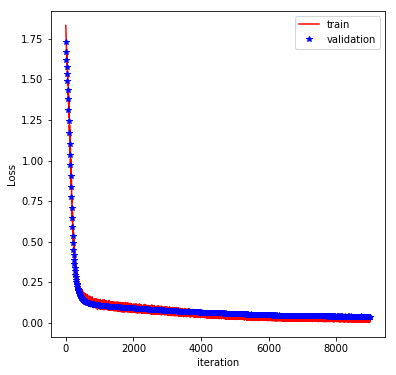

In [13]:
# Plot training and test loss
t = np.arange(iteration-1)

plt.figure(figsize = (6,6))
plt.plot(t, np.array(train_loss), 'r-', t[t % 10 == 0], np.array(validation_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

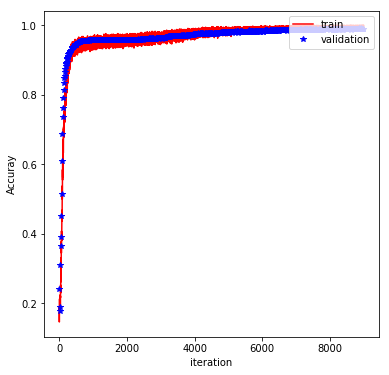

In [14]:
# Plot Accuracies
plt.figure(figsize = (6,6))

plt.plot(t, np.array(train_acc), 'r-', t[t % 10 == 0], validation_acc, 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuray")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Evaluate on test set

In [15]:
test_acc = []

with tf.Session(graph=graph) as sess:
    # Restore
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints-cnn'))
    
    for x_t, y_t in get_batches(X_test, y_test, batch_size):
        feed = {inputs_: x_t,
                labels_: y_t,
                keep_prob_: 1}
        
        batch_acc = sess.run(accuracy, feed_dict=feed)
        test_acc.append(batch_acc)
    print("Test accuracy: {:.6f}".format(np.mean(test_acc)))

Test accuracy: 0.930417
